In [1]:
from utils import CustomDataset, transform, Convert_ONNX
from utils_batched_preproc import transform_batched, preproc_flip
from torch.utils.data import Dataset, DataLoader
import torch
import numpy as np
from resnet_model_mask import  ResidualBlock, ResNet
import torch
import torch.nn as nn
import torch.optim as optim
import tqdm 
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau
import pickle
import torch
from functorch import vmap

In [2]:
# def renorm_batched(data):
#     mean = torch.mean(data, dim=tuple(range(1, data.ndim)), keepdim=True)
#     std = torch.std(data, dim=tuple(range(1, data.ndim)), keepdim=True)
#     standardized_data = (data - mean) / std
#     return standardized_data

# def transform_batched(data):
#     copy_data = data.detach().clone()
#     rms = torch.std(data, dim=tuple(range(1, data.ndim)), keepdim=True)  # Batch-wise std
#     mean = torch.mean(data, dim=tuple(range(1, data.ndim)), keepdim=True)  # Batch-wise mean
#     masks_rms = [-1, 5]
    
#     # Prepare the new_data tensor
#     num_masks = len(masks_rms) + 1
#     new_data = torch.zeros((num_masks, *data.shape), device=data.device)  # Shape: (num_masks, batch_size, ..., ...)

#     # First layer: Apply renorm(log10(copy_data + epsilon))
#     new_data[0] = renorm_batched(torch.log10(copy_data + 1e-10))
#     for i, scale in enumerate(masks_rms, start=1):
#         copy_data = data.detach().clone()
        
#         # Apply masking based on the scale
#         if scale < 0:
#             ind = copy_data < abs(scale) * rms + mean
#         else:
#             ind = copy_data > scale * rms + mean
#         copy_data[ind] = 0
        
#         # Renormalize and log10 transform
#         new_data[i] = renorm_batched(torch.log10(copy_data + 1e-10))
    
#     # Convert to float32
#     new_data = new_data.type(torch.float32)

#     # Chunk along the last dimension and stack
#     slices = torch.chunk(new_data, 8, dim=-1)  # Adjust for batch-wise slicing
#     new_data = torch.stack(slices, dim=2)  # Insert a new axis at dim=1
#     new_data = torch.swapaxes(new_data, 0,1)
#     # Reshape into final format
#     new_data = new_data.reshape( new_data.size(0), 24,  new_data.size(3), new_data.size(4))  # Flatten batch and mask dimensions
#     return new_data




In [3]:
model_path = 'models/model-47-99.125.pt'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = ResNet(24, ResidualBlock, [3, 4, 6, 3], num_classes=2).to(device)
model = nn.DataParallel(model)
model = model.to(device)
model.load_state_dict(torch.load(model_path))
model.eval()

num params encoder  50840


/tmp/ipykernel_19630/1680389579.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


DataParallel(
  (module): ResNet(
    (relu): ReLU()
    (conv1): Sequential(
      (0): Conv2d(24, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (maxpool): MaxPool2d(kernel_size=(2, 2), stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer0): Sequential(
      (0): ResidualBlock(
        (conv1): Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
        )
        (conv2): Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (relu): ReLU()
        (dropout1): Dropout(p=0.5, inplace=False)
        (batchnorm_mod): BatchNorm2d(64, eps=1e-05, moment

In [4]:
test_in = abs(torch.randn(32, 192, 2048).to(device))
results = []
for i in range(32):
    results.append(transform(test_in[i,:,:]))
intermediate = torch.stack(results).cuda()
out = model(intermediate)
test_in.cpu().detach().numpy().tofile("input.bin")
intermediate.cpu().detach().numpy().tofile("intermediate.bin")
out.cpu().detach().numpy().tofile("output.bin")
print(out)

/home/pma/.conda/envs/frbnn/lib/python3.11/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


tensor([[ 4.8915, -4.9161],
        [ 4.6655, -4.6752],
        [ 5.5483, -5.5774],
        [ 4.8304, -4.8082],
        [ 4.9845, -5.0127],
        [ 5.2005, -5.2146],
        [ 3.9998, -4.0095],
        [ 5.4356, -5.4543],
        [ 4.8043, -4.7968],
        [ 5.0922, -5.1002],
        [ 5.0995, -5.1018],
        [ 5.0935, -5.0993],
        [ 3.0471, -3.0477],
        [ 4.6315, -4.6426],
        [ 5.4862, -5.4925],
        [ 5.3443, -5.3469],
        [ 5.4950, -5.4840],
        [ 5.0470, -5.0560],
        [ 4.6688, -4.6976],
        [ 5.4871, -5.5073],
        [ 4.1512, -4.1532],
        [ 3.9549, -3.9522],
        [ 5.1378, -5.1412],
        [ 2.7567, -2.7387],
        [ 5.4816, -5.4770],
        [ 5.5389, -5.5707],
        [ 4.4332, -4.4744],
        [ 4.9961, -4.9969],
        [ 5.3274, -5.3498],
        [ 5.1709, -5.1876],
        [ 4.2094, -4.1988],
        [ 4.5206, -4.5567]], device='cuda:0', grad_fn=<GatherBackward>)


In [5]:
preproc_model = preproc_flip()
Convert_ONNX(preproc_model,f'models_mask/preproc_flip.onnx', input_data_mock=test_in.to(device))
# Convert_ONNX(model.module,f'models_mask/model_test.onnx', input_data_mock=intermediate.to(device))

Saving to ONNX
 
Model has been converted to ONNX


In [7]:
test_in.shape

torch.Size([32, 192, 2048])

In [13]:
import torch
torch.flip(test_in[0,:,:], dims = (0,)) - torch.flipud(test_in[0,:,:])

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0')

In [29]:
import onnxruntime as ort
import onnx

# Path to your ONNX model
model_path = "models/model-47-99.125.onnx"

# Load the ONNX model
session = ort.InferenceSession(model_path)

# Get input and output details
input_name = session.get_inputs()[0].name
output_name = session.get_outputs()[0].name

print(session.get_inputs()[0].type)
print(test_in.dtype)

print(f"Input Name: {input_name}")
print(f"Output Name: {output_name}")

# Example Input Data (Replace with your actual input data)
import numpy as np

# Perform inference
outputs = session.run([output_name], {input_name: intermediate.cpu().numpy()})
print(outputs)

onnx_model = onnx.load(model_path)

tensor(float)
torch.float32
Input Name: modelInput
Output Name: modelOutput
[array([[ 4.3262615, -4.3409047],
       [ 4.9648395, -4.968621 ],
       [ 5.5126643, -5.522872 ],
       [ 4.7735534, -4.8004475],
       [ 4.0924144, -4.112945 ],
       [ 4.588802 , -4.6043544],
       [ 4.6231914, -4.617625 ],
       [ 5.229881 , -5.2555394],
       [ 4.877381 , -4.882144 ],
       [ 5.2514744, -5.2786503],
       [ 4.2948875, -4.3169603],
       [ 4.5997186, -4.6177607],
       [ 4.9509926, -4.9685597],
       [ 4.933158 , -4.9568825],
       [ 4.747336 , -4.7639017],
       [ 5.020595 , -5.0202913],
       [ 4.914437 , -4.9206715],
       [ 5.193108 , -5.1925435],
       [ 4.5233765, -4.512763 ],
       [ 4.7573333, -4.762632 ],
       [ 5.268702 , -5.2838397],
       [ 4.857734 , -4.8605857],
       [ 5.1886744, -5.2047734],
       [ 5.512568 , -5.5503583],
       [ 5.320961 , -5.344709 ],
       [ 4.1023226, -4.1073256],
       [ 5.17857  , -5.185736 ],
       [ 4.997028 , -4.9933476],

In [30]:
# import onnxruntime as ort
# import onnx

# # Path to your ONNX model
# model_path = "models_mask/preproc_test.onnx"

# # Load the ONNX model
# session = ort.InferenceSession(model_path)

# # Get input and output details
# input_name = session.get_inputs()[0].name
# output_name = session.get_outputs()[0].name

# print(session.get_inputs()[0].type)
# print(test_in.dtype)

# print(f"Input Name: {input_name}")
# print(f"Output Name: {output_name}")

# # Example Input Data (Replace with your actual input data)
# import numpy as np

# # Perform inference
# outputs = session.run([output_name], {input_name: test_in.cpu().numpy()})
# print("Model Output:", outputs)

# onnx_model = onnx.load(model_path)

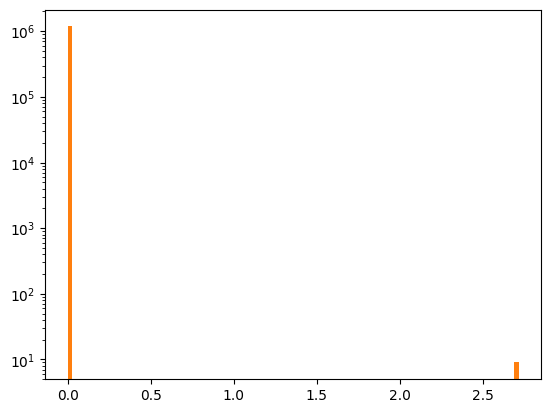

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(abs(intermediate-outputs[0]).ravel(), bins = 100)
plt.yscale('log')
plt.show()

In [15]:
torch.sort(abs(intermediate-outputs[0]).ravel())[0][-10:]

tensor([1.1902e-03, 2.7140e+00, 2.7140e+00, 2.7140e+00, 2.7140e+00, 2.7140e+00,
        2.7140e+00, 2.7140e+00, 2.7140e+00, 2.7140e+00])

In [ ]:
import onnxruntime as ort

session_options = ort.SessionOptions()
session_options.log_severity_level = 0  # Verbose logging
session = ort.InferenceSession("models_mask/preproc_test.onnx", sess_options=session_options)

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(outputs[0][0,8,:,:])
plt.show()

In [ ]:
import onnx

# Path to your ONNX model
model_path = "models/model-47-99.125.onnx"

# Load the ONNX model
onnx_model = onnx.load(model_path)

# Check the model for validity
onnx.checker.check_model(onnx_model)

# Print model graph structure (optional)
print(onnx.helper.printable_graph(onnx_model.graph))
